In [32]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import h5py

from tqdm import tqdm
from glob import glob
from os import makedirs
import dill

In [33]:
# set to true to disable nerual network outputs and use the best-case targets as predictions
PERFECT = False
CHI2 = False
NPZ_FILE = "./data/results_2020_10_17_nofilter.npz"
ALPHA=0.1
TITLE_SIZE = 45

NNET_NAME = r"\textsc{Spa-Net}"
NNET_NAME = r"\textsc{Spa}$t\bar{t}$\textsc{er}"
NNET_NAME = r"\textsc{Spa}$t\bar{t}$\hspace{0.05em}\textsc{er}"

SHARED_PLOTS = False

In [34]:
if CHI2:
    chi2_storage = []
    NUM_CHI2 = 59

    for i in tqdm(range(NUM_CHI2)):
        with h5py.File(f"./backup/evaluate_new_with_JES/output_vector_{i + 1}.h5", 'r') as file:
            chi2_result = np.stack(file["Chi2_result"][:]).astype(np.int)
        chi2_storage.append(chi2_result)

    chi2_result = np.concatenate(chi2_storage)
    del chi2_storage
    
    verify_sum = chi2_result[:, [1, 2]].sum(1)
    should_swap = chi2_result[:, 1] > chi2_result[:, 2]
    chi2_result[should_swap, 1], chi2_result[should_swap, 2] = chi2_result[should_swap, 2], chi2_result[should_swap, 1]

    assert (chi2_result[:, [1, 2]].sum(1) == verify_sum).all()

    verify_sum = chi2_result[:, [4, 5]].sum(1)
    should_swap = chi2_result[:, 4] > chi2_result[:, 5]
    chi2_result[should_swap, 4], chi2_result[should_swap, 5] = chi2_result[should_swap, 5], chi2_result[should_swap, 4]

    assert (chi2_result[:, [4, 5]].sum(1) == verify_sum).all()

In [35]:
results = np.load(NPZ_FILE)
full_dataset = results["dataset"]
full_predictions = results["predictions"]
full_targets = results["targets"]
n_match = results["n_match"]
num_samples = full_predictions.shape[0]

num_jets = (full_dataset.sum(-1) > 0).sum(-1)

if PERFECT:
    full_predictions = full_targets
    
if CHI2:
    full_predictions = chi2_result[:num_samples]

In [36]:
# JET_LIMIT = num_jets == 6
# JET_LIMIT = num_jets == 7
# JET_LIMIT = num_jets >= 8

In [37]:
try:
    full_dataset = full_dataset[JET_LIMIT]
    full_predictions = full_predictions[JET_LIMIT]
    full_targets = full_targets[JET_LIMIT]
    n_match = n_match[JET_LIMIT]
except NameError:
    pass

In [38]:
# Triplet posibilities
# 0: Correct
# 1: Incorrect
# 2: Non-match i.e. impossible
correct = []
incorrect = []
non_match = []

In [39]:
# 2 Top-quark accuracy calculations
# #############################################################################

twin_idx = n_match == 2
twin_dummy_idx = np.arange(twin_idx.sum()).reshape(-1, 1)

# Get the associated targets, prediction, and vectors
# Split into the two triplets (b1, q1, q2) -> Left and (b2, q3, q4) -> Right
left_targets = full_targets[twin_idx, :3]
right_targets = full_targets[twin_idx, 3:]

left_predictions = full_predictions[twin_idx, :3]
right_predictions = full_predictions[twin_idx, 3:]

twin_dataset = full_dataset[twin_idx]
left_vectors = twin_dataset[twin_dummy_idx, left_predictions]
right_vectors = twin_dataset[twin_dummy_idx, right_predictions]

# Compute which predictions are correct and not correct
# We enfore C-symmetry here by taking the or with both targets
left_correct = (left_targets == left_predictions).all(1) | (right_targets == left_predictions).all(1)
right_correct = (left_targets == right_predictions).all(1) | (right_targets == right_predictions).all(1)

# We enforce qq symmetry by enforcing that the lower index jet must come first
assert (left_predictions[:, 1] < left_predictions[:, 2]).all()
assert (right_predictions[:, 1] < right_predictions[:, 2]).all()

assert (left_targets[:, 1] < left_targets[:, 2]).all()
assert (right_targets[:, 1] < right_targets[:, 2]).all()

# Helper arrays for purity calculation
both_correct = left_correct & right_correct
either_correct = left_correct | right_correct

# Add any predictions that ended being correct to the list of correct vectors
correct.append(left_vectors[left_correct])
correct.append(right_vectors[right_correct])

# Other vectors for 2 top-quark are gauranteed to be incorrect
incorrect.append(left_vectors[~left_correct])
incorrect.append(right_vectors[~right_correct])

twin_left_vectors = left_vectors
twin_right_vectors = right_vectors

# For 2-top events, event purity is the number of times we got both triplets correct
twin_event_purity_filtered = (left_correct & right_correct).mean()

# For 2-top events, top purity is number of tops we got correct / (2 * number of events) <- (total number of tops)
twin_top_purity_filtered = (left_correct.sum() + right_correct.sum()) / (2 * right_correct.shape[0])

In [40]:
full_targets[1,:3]

array([-1, -1, -1])

In [41]:
(n_match == 1)[:30]

array([False,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True, False, False, False, False, False,
       False, False,  True])

In [42]:
full_predictions[6]

array([2, 1, 3, 0, 4, 5])

In [43]:
# 1 Top-quark accuracy calculations
# #############################################################################

single_idx = n_match == 1
print(single_idx[14])
# Get the associated targets, prediction, and vectors
# Split into the two triplets (b1, q1, q2) -> Left and (b2, q3, q4) -> Right
left_targets = full_targets[single_idx, :3]
right_targets = full_targets[single_idx, 3:]
print(left_targets[14], right_targets[14])

left_predictions = full_predictions[single_idx, :3]
right_predictions = full_predictions[single_idx, 3:]
print(left_predictions[14], right_predictions[14])
single_dataset = full_dataset[single_idx]
single_dummy_idx = np.arange(single_idx.sum()).reshape(-1, 1)
left_vectors = single_dataset[single_dummy_idx, left_predictions]
right_vectors = single_dataset[single_dummy_idx, right_predictions]

# Find the one triplet that is complete in the targets
left_jets = np.fromiter(map(lambda x: (x >= 0).sum(), left_targets), np.int64, single_idx.sum())
right_jets = np.fromiter(map(lambda x: (x >= 0).sum(), right_targets), np.int64, single_idx.sum())

single_targets = np.zeros_like(left_targets)
single_targets[left_jets == 3] = left_targets[left_jets == 3]
single_targets[right_jets == 3] = right_targets[right_jets == 3]

# Check that there is exactly one target per event
assert ((left_jets == 3) ^ (right_jets == 3)).all()

# Each branch is correct if it matches the single target
left_correct = (single_targets == left_predictions).all(1)
right_correct = (single_targets == right_predictions).all(1)

# If a branch didnt get a prediction correct, BUT the other branch did, then this prediction was just impossible!
impossible_left = ~left_correct & right_correct
impossible_right = ~right_correct & left_correct

# Because the three posibility are mutually exclusive, we can just 
# quickly compute the incorrect vectors with some boolean algebra
# We will double up incorrect if we include both, so lets just say that 
# the left one is incorrect and the other one was impossible
# The choice is arbitrary
left_incorrect = ~(left_correct | impossible_left)
impossible_right_2 = ~(right_correct | impossible_right)

correct.append(left_vectors[left_correct])
correct.append(right_vectors[right_correct])

non_match.append(left_vectors[impossible_left])
non_match.append(right_vectors[impossible_right])
non_match.append(right_vectors[impossible_right_2])

incorrect.append(left_vectors[left_incorrect])

# For 1-top events, top purity is just the number of tops we got correct / number of events since only 1 top chance per.
single_top_purity_filtered = (left_correct.sum() + right_correct.sum()) / (right_correct.shape[0])

False
[-1 -1 -1] [5 1 2]
[5 1 2] [4 0 3]


In [44]:
left_correct[:20]

array([False, False, False, False, False,  True,  True, False, False,
        True, False, False, False, False,  True, False, False,  True,
       False, False])

In [45]:
right_correct[:20]

array([ True, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False,  True])

In [46]:
print(type(left_correct), left_correct[:10], right_correct.shape[0], right_correct.sum())

<class 'numpy.ndarray'> [False False False False False  True  True False False  True] 619716 71337


In [47]:
# 0 Top-quark accuracy calculations
# #############################################################################

zero_idx = n_match == 0

# All vectors here are gauranteed to be no-match
left_predictions = full_predictions[zero_idx, :3]
right_predictions = full_predictions[zero_idx, 3:]

zero_dataset = full_dataset[zero_idx]
zero_dummy_idx = np.arange(zero_idx.sum()).reshape(-1, 1)
left_vectors = zero_dataset[zero_dummy_idx, left_predictions]
right_vectors = zero_dataset[zero_dummy_idx, right_predictions]

non_match.append(left_vectors)
non_match.append(right_vectors)

In [48]:
correct = np.concatenate(correct)
incorrect = np.concatenate(incorrect)
non_match = np.concatenate(non_match)

# We should have two vectors per original event
assert (correct.shape[0] + incorrect.shape[0] + non_match.shape[0]) / 2 == full_dataset.shape[0]

# If we're doing a perfect test, then we should have no incorrect vectors
if PERFECT:
    assert incorrect.shape[0] == 0

In [49]:
print(f"Total number of correct top quarks   : {correct.shape[0]}")
print(f"Total number of incorrect top quarks : {incorrect.shape[0]}")
print(f"Total number of incomplete top quarks: {non_match.shape[0]}")

Total number of correct top quarks   : 983052
Total number of incorrect top quarks : 410606
Total number of incomplete top quarks: 974854


In [50]:
print(f"Top Purity (Unfiltered): {len(correct) / (len(correct) + len(incorrect) + len(non_match)):.3f}")
print(f"Top Purity (1 Top Events): {single_top_purity_filtered:.3f}")
print(f"Top Purity (2 Top Events): {twin_top_purity_filtered:.3f}")

print()
print(f"Event Purity (Unfiltered): {both_correct.sum() / full_dataset.shape[0]:.3f}")
print(f"Event Purity (2 Top Events): {twin_event_purity_filtered:.3f}")

print()
print(f"Total ratio of 0 top events: {(n_match == 0).mean():.3f}")
print(f"Total ratio of 1 top events: {(n_match == 1).mean():.3f}")
print(f"Total ratio of 2 top events: {(n_match == 2).mean():.3f}")

print()
print("-" * 80)
print(f"Top Purity (1 Top Events): {single_top_purity_filtered:.3f}")
print(f"Top Purity (2 Top Events): {twin_top_purity_filtered:.3f}")
print(f"Event Purity (2 Top Events): {twin_event_purity_filtered:.3f}")

Top Purity (Unfiltered): 0.415
Top Purity (1 Top Events): 0.451
Top Purity (2 Top Events): 0.909

Event Purity (Unfiltered): 0.283
Event Purity (2 Top Events): 0.867

Total ratio of 0 top events: 0.150
Total ratio of 1 top events: 0.523
Total ratio of 2 top events: 0.327

--------------------------------------------------------------------------------
Top Purity (1 Top Events): 0.451
Top Purity (2 Top Events): 0.909
Event Purity (2 Top Events): 0.867


In [51]:
both_correct.sum()

335557

$$(E_1 + E_2)^2 - ||p_1 + p_2||^2$$

In [52]:
# def invariant_mass(vectors):
#     # vectors shape: (E, V, D)
#     # E: Number of events (batch computation)
#     # V: Number of vectors in each event
#     # D: Component dimension, order listed below
#     Pt, mass, phi, eta, btag = vectors.transpose(2, 0, 1)
    
#     scale = 1.0426366329193115
#     Pt = Pt * scale
#     mass = mass * scale
    
#     Px = Pt * np.cos(phi)
#     Py = Pt * np.sin(phi)
#     Pz = Pt * np.sinh(eta)
#     E = np.sqrt( Px**2 + Py**2 + Pz**2 + mass**2)

#     return np.sqrt(E.sum(1) ** 2 - Px.sum(1) ** 2 - Py.sum(1) ** 2 - Pz.sum(1) ** 2)

In [53]:
def invariant_mass(vectors):
    # vectors shape: (E, V, D)
    # E: Number of events (batch computation)
    # V: Number of vectors in each event
    # D: Component dimension, order listed below
    mass, Pt, eta, phi, btag = vectors.transpose(2, 0, 1)
    
    scale = -0.0008228230613626063 * Pt - 0.051359995969670155
    scale = 1 - (scale / 2)

    Pt = Pt * scale
    mass = mass * scale
    
    Px = Pt * np.cos(phi)
    Py = Pt * np.sin(phi)
    Pz = Pt * np.sinh(eta)
    E = np.sqrt( Px**2 + Py**2 + Pz**2 + mass**2)

    return np.sqrt(E.sum(1) ** 2 - Px.sum(1) ** 2 - Py.sum(1) ** 2 - Pz.sum(1) ** 2)

In [54]:
t_correct = invariant_mass(correct)
t_incorrect = invariant_mass(incorrect)
t_non_match = invariant_mass(non_match)

W_correct = invariant_mass(correct[:, 1:])
W_incorrect = invariant_mass(incorrect[:, 1:])
W_non_match = invariant_mass(non_match[:, 1:])

In [55]:
ttbar = twin_dataset[np.arange(twin_dataset.shape[0]).reshape(-1, 1), full_predictions[twin_idx]]
ttbar = invariant_mass(ttbar)

In [56]:
if PERFECT:
    W_non_match = np.array([])
    t_non_match = np.array([])

In [57]:
sb.set(context='paper', style='whitegrid', font_scale=4.0)
makedirs("./figures/", exist_ok=True)
rcParams['text.usetex'] = True
rcParams['hatch.linewidth'] = 6

In [58]:
from matplotlib import ticker
mkfunc = lambda x, pos: '%1.0f M' % (x * 1e-6) if x >= 1e6 else '$%1.0f$K' % (x * 1e-3) if x >= 1e3 else '%1.0f' % x
mkformatter = ticker.FuncFormatter(mkfunc)

In [59]:
MODEL_NAME = NNET_NAME
if CHI2:
    MODEL_NAME = "$\\chi^2$ Model."
    
if PERFECT:
    MODEL_NAME = "Ground Truth."

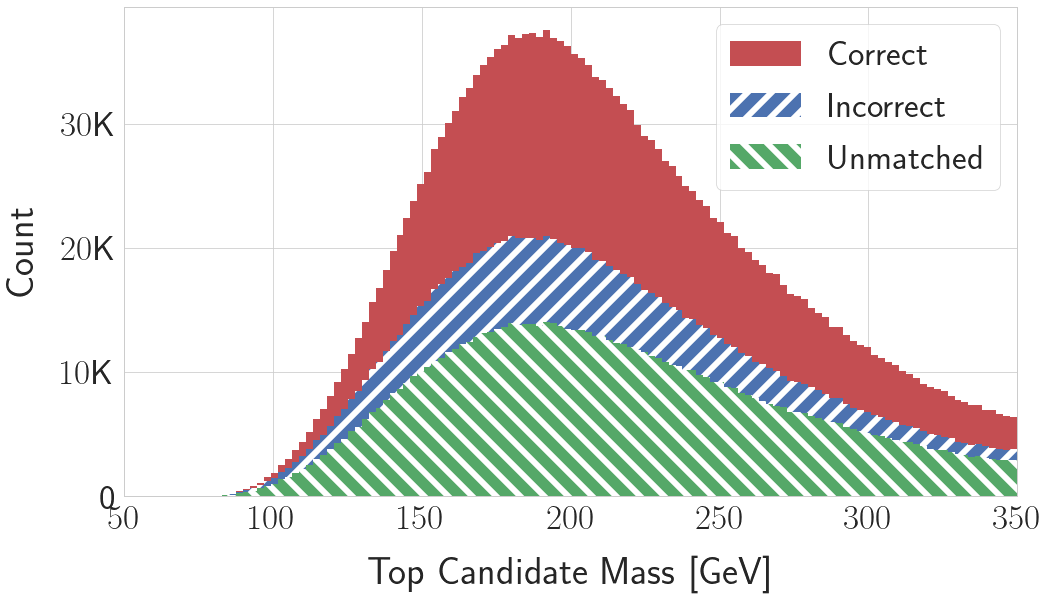

In [60]:
fig, ax = plt.subplots(figsize=(16,9))
plt.hist(np.concatenate([t_non_match, t_incorrect, t_correct]), 128, color="r", range=(50,350), label='Correct', linewidth=0.00, antialiased=True); 
plt.hist(np.concatenate([t_non_match, t_incorrect]), 128, color="b", hatch='/', range=(50,350), label='Incorrect', linewidth=0.00, antialiased=True); 
plt.hist(t_non_match, 128, color="g", range=(50,350), hatch='\\', label="Unmatched", linewidth=0.00, antialiased=True); 

# plt.hist(np.concatenate([t_non_match, t_incorrect, t_correct]), 128, color="w", range=(50,350), histtype='step', linewidth=2.0); 
# plt.hist(np.concatenate([t_non_match, t_incorrect]), 128, color="w", range=(50,350), histtype='step', linewidth=2.0); 


# plt.hist((t_non_match, t_incorrect, t_correct), 128, stacked=True, color=["g", "b", "r"], range=(50,350), hatch='x'); 


# plt.title(f"$t$ Quark Invariant Mass Stacked Histogram. {MODEL_NAME}", pad=20, fontsize= TITLE_SIZE)


plt.xlabel("Top Candidate  Mass [GeV]", labelpad=20)
plt.ylabel("Count", labelpad=20)
plt.xticks()
plt.xlim(50, 350)
# plt.yticks(plt.yticks()[0][1:])


# plt.axvline(173, color='m', linewidth=6)

plt.legend()
ax.yaxis.set_major_formatter(mkformatter)
# plt.yticks(np.array([10_000, 30_000, 50_000, 70_000]))
# plt.ylim(0, 80_000)



# plt.tight_layout()
# plt.savefig(f"./figures/network_t_quark_stacked{'_perfect' if PERFECT else ''}{'_chi2' if CHI2 else ''}.pdf", bbox_inches='tight')

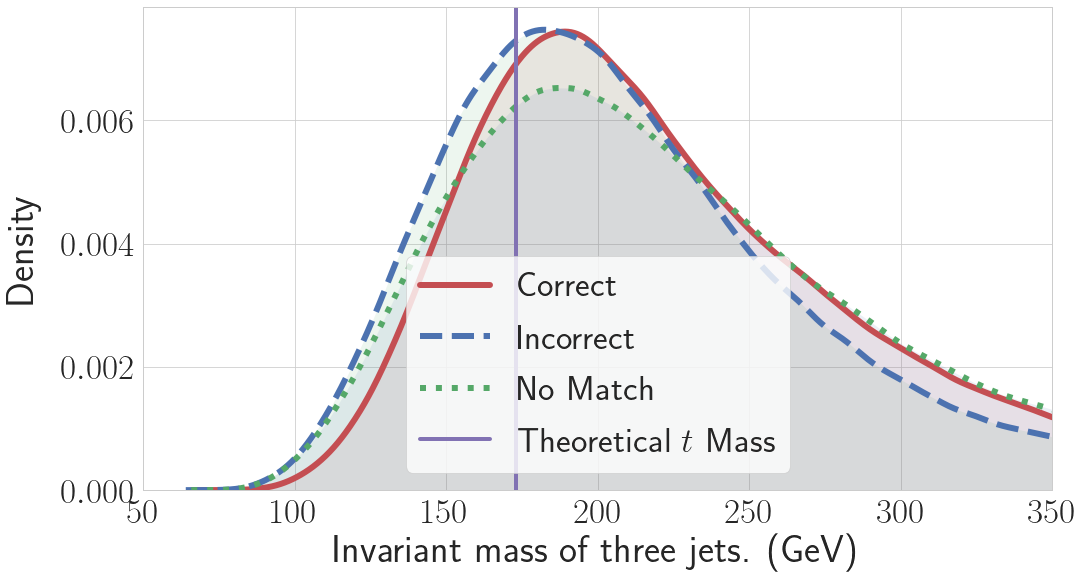

In [61]:
plt.figure(figsize=(16,9))

sb.kdeplot(t_correct[t_correct < 400], color='r', shade=False, gridsize=1024, linewidth=6,
           label=f"Correct")
sb.kdeplot(t_incorrect[t_incorrect < 400], color='b', shade=False, gridsize=1024, linestyle='--', linewidth=6,
          label=f"Incorrect")
sb.kdeplot(t_non_match[t_non_match < 400], color='g', shade=False, gridsize=1024, linestyle=':', linewidth=6,
           label=f"No Match")

sb.kdeplot(t_correct[t_correct < 400], color='r', linewidth=0, shade=True, gridsize=1024, alpha=ALPHA)
sb.kdeplot(t_incorrect[t_incorrect < 400], color='g', linewidth=0, shade=True, gridsize=1024, alpha=ALPHA)
sb.kdeplot(t_non_match[t_non_match < 400], color='b', linewidth=0, shade=True, gridsize=1024, alpha=ALPHA)

# plt.title(f"$t$ Quark Invariant Mass Relative Distributions. {MODEL_NAME}", pad=20, fontsize= TITLE_SIZE)


plt.xlabel("Invariant mass of three jets. (GeV)")
plt.ylabel("Density", labelpad=20)
plt.xlim(50, 350)
# plt.ylim(0, 0.026)

plt.axvline(173, color='m', label="Theoretical $t$ Mass", linewidth=4)

plt.legend()

plt.tight_layout()
plt.savefig(f"./figures/network_t_quark_relative{'_perfect' if PERFECT else ''}{'_chi2' if CHI2 else ''}.pdf", bbox_inches='tight')

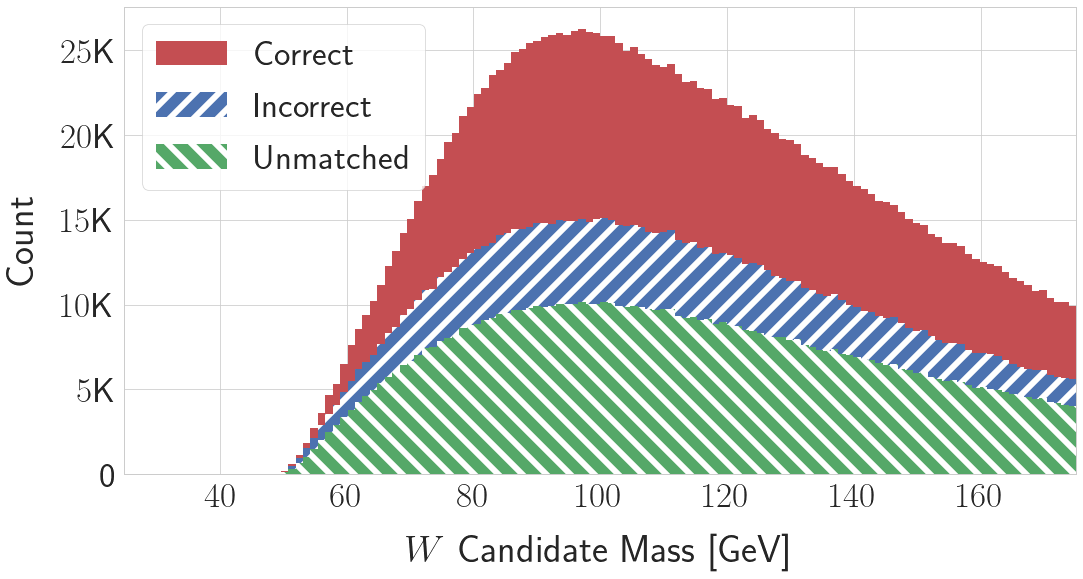

In [62]:
fig, ax = plt.subplots(figsize=(16,9))

plt.hist(np.concatenate([W_non_match, W_incorrect, W_correct]), 128, color="r", range=(25, 175), label='Correct', linewidth=0.0, antialiased=True); 
plt.hist(np.concatenate([W_non_match, W_incorrect]), 128, color="b", range=(25, 175), hatch='/', label='Incorrect', linewidth=0.0, antialiased=True); 
plt.hist(W_non_match, 128, color="g", range=(25, 175), hatch='\\', label="Unmatched", linewidth=0.0, antialiased=True); 

# plt.hist(np.concatenate([t_non_match, t_incorrect, t_correct]), 128, color="w", range=(50,350), histtype='step', linewidth=2.0); 
# plt.hist(np.concatenate([t_non_match, t_incorrect]), 128, color="w", range=(50,350), histtype='step', linewidth=2.0); 


# plt.hist((t_non_match, t_incorrect, t_correct), 128, stacked=True, color=["g", "b", "r"], range=(50,350), hatch='x'); 


# plt.title(f"$t$ Quark Invariant Mass Stacked Histogram. {MODEL_NAME}", pad=20, fontsize= TITLE_SIZE)


plt.xlabel("$W$ Candidate Mass [GeV]", labelpad=20)
plt.ylabel("Count", labelpad=20)
plt.xticks()
plt.xlim(25, 175)


# plt.axvline(173, color='m', linewidth=6)

plt.legend()
ax.yaxis.set_major_formatter(mkformatter)
# plt.yticks(np.array([25_000, 50_000, 75_000, 100_000]))
# plt.ylim(0, 100_000)

plt.tight_layout()
plt.savefig(f"./figures/network_w_quark_stacked{'_perfect' if PERFECT else ''}{'_chi2' if CHI2 else ''}.pdf", bbox_inches='tight')

In [63]:
plt.figure(figsize=(16,9))

sb.kdeplot(W_correct[W_correct < 200], color='r', shade=False, gridsize=1024, linewidth=6,
           label=f"Correct")
sb.kdeplot(W_incorrect[W_incorrect < 200], color='b', shade=False, gridsize=1024, linewidth=6, linestyle='--',
          label=f"Incorrect")
sb.kdeplot(W_non_match[W_non_match < 200], color='g', shade=False, gridsize=1024, linewidth=6, linestyle=':',
           label=f"No Match")

sb.kdeplot(W_correct[W_correct < 200], color='r', linewidth=0, shade=True, gridsize=1024, alpha=ALPHA)
sb.kdeplot(W_incorrect[W_incorrect < 200], color='g', linewidth=0, shade=True, gridsize=1024, alpha=ALPHA)
sb.kdeplot(W_non_match[W_non_match < 200], color='b', linewidth=0, shade=True, gridsize=1024, alpha=ALPHA)

# plt.title(f"$W$ Boson Invariant Mass Relative Distributions. {MODEL_NAME}", pad=20, fontsize= TITLE_SIZE)


plt.xlabel("Invariant mass of two jets. (GeV)")
plt.ylabel("Density", labelpad=20)
plt.xlim(25, 175)
plt.ylim(0, 0.048)

plt.axvline(80.4, color='m', label="Theoretical $W$ Mass", linewidth=4)

plt.legend()
plt.tight_layout()
plt.savefig(f"./figures/network_w_quark_relative{'_perfect' if PERFECT else ''}{'_chi2' if CHI2 else ''}.pdf", bbox_inches='tight')

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16,9))

sb.kdeplot(invariant_mass(twin_left_vectors), gridsize=8192, label='Left Predictions', shade=False, color='b');
sb.kdeplot(invariant_mass(twin_right_vectors), gridsize=8192, label='Right Predictions', shade=False, color='r');

sb.kdeplot(invariant_mass(twin_left_vectors), color='b', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
sb.kdeplot(invariant_mass(twin_right_vectors), color='r', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)

lm = invariant_mass(twin_left_vectors).mean()
rm = invariant_mass(twin_right_vectors).mean()
plt.axvline(lm, label=f'Left Predictions Mean = {lm:.3f}', color='b')
plt.axvline(rm, label=f'Right Predictions Mean = {rm:.3f}', color='r')

plt.legend()
plt.xlim(50, 300)

In [ ]:
# with open("./network.pickle", 'wb') as file:
#     dill.dump([t_correct, t_incorrect, t_non_match, W_correct, W_incorrect, W_non_match, ttbar], file)

In [ ]:
with open("./chi2.pickle", 'wb') as file:
    dill.dump([t_correct, t_incorrect, t_non_match, W_correct, W_incorrect, W_non_match, ttbar], file)

In [ ]:
# with open("./perfect.pickle", 'wb') as file:
#     dill.dump([t_correct, t_incorrect, t_non_match, W_correct, W_incorrect, W_non_match, ttbar], file)

In [ ]:
# SHARED_PLOTS = True

In [ ]:
if SHARED_PLOTS:
    with open("./perfect.pickle", 'rb') as file:
        perfect = dill.load(file)

    with open("./chi2.pickle", 'rb') as file:
        chi2 = dill.load(file)

    with open("./network.pickle", 'rb') as file:
        network = dill.load(file)

    plt.figure(figsize=(16,9))

    sb.kdeplot(perfect[0], color='r', shade=False, gridsize=8192, linewidth=6,
               label=f"Ground Truth")
    sb.kdeplot(network[0], color='b', shade=False, gridsize=8192, linewidth=6, linestyle='--',
               label=NNET_NAME)
    sb.kdeplot(chi2[0], color='g', shade=False, gridsize=8192, linewidth=6, linestyle=':',
              label=f"$\\chi^2$")
    

    sb.kdeplot(perfect[0], color='r', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(chi2[0], color='g', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(network[0], color='b', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)

    plt.title(f"$t$ Quark Invariant Mass Distribution Comparison. Correctly Matched Instances.", pad=20, fontsize= TITLE_SIZE)


    plt.xlabel("Invariant mass of two jets. (GeV)")
    plt.ylabel("Density", labelpad=20)
    plt.xlim(50, 350)
    plt.ylim(0, 0.026)
    plt.axvline(173, color='m', label="Theoretical $t$ Mass", linewidth=4)

    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./figures/correct_comparison.pdf", bbox_inches='tight')

In [ ]:
if SHARED_PLOTS:
    with open("./perfect.pickle", 'rb') as file:
        perfect = dill.load(file)

    with open("./chi2.pickle", 'rb') as file:
        chi2 = dill.load(file)

    with open("./network.pickle", 'rb') as file:
        network = dill.load(file)

    plt.figure(figsize=(16,9))

    sb.kdeplot(perfect[0], color='r', shade=False, gridsize=8192, linewidth=6, 
               label=f"Ground Truth")
    sb.kdeplot(network[1], color='b', shade=False, gridsize=8192, linewidth=6, linestyle='--',
               label=NNET_NAME)
    sb.kdeplot(chi2[1], color='g', shade=False, gridsize=8192, linewidth=6, linestyle=':',
              label=f"$\\chi^2$")
    

    sb.kdeplot(perfect[0], color='r', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(chi2[1], color='g', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(network[1], color='b', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)

    plt.title(f"$t$ Quark Invariant Mass Distribution Comparison. Incorrectly Matched Instances.", pad=20, fontsize= TITLE_SIZE)


    plt.xlabel("Invariant mass of two jets. (GeV)")
    plt.ylabel("Density", labelpad=20)
    plt.xlim(50, 350)
    plt.ylim(0, 0.026)
    plt.axvline(173, color='m', label="Theoretical $t$ Mass", linewidth=4)

    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./figures/incorrect_comparison.pdf", bbox_inches='tight')

In [ ]:
if SHARED_PLOTS:
    with open("./perfect.pickle", 'rb') as file:
        perfect = dill.load(file)

    with open("./chi2.pickle", 'rb') as file:
        chi2 = dill.load(file)

    with open("./network.pickle", 'rb') as file:
        network = dill.load(file)

    plt.figure(figsize=(16,9))

    chi2_ = np.concatenate((chi2[0], chi2[1]))
    network_ = np.concatenate((network[0], network[1]))


    sb.kdeplot(perfect[0], color='r', shade=False, gridsize=8192, linewidth=8, 
               label=f"Ground Truth")
    sb.kdeplot(network_, color='b', shade=False, gridsize=8192, linewidth=8,  linestyle='--',
               label=NNET_NAME)
    sb.kdeplot(chi2_, color='g', shade=False, gridsize=8192, linewidth=8,  linestyle=':',
              label=f"$\\chi^2$")
    

    sb.kdeplot(perfect[0], color='r', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(chi2_, color='g', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(network_, color='b', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)

#     plt.title(f"$t$ Quark Invariant Mass Distribution Comparison. All Possible Instances.", pad=20, fontsize= TITLE_SIZE)
#     plt.title(f"$t$ Quark Invariant Mass Distribution Comparison.", pad=20, fontsize= TITLE_SIZE)


    plt.xlabel("Top Candidate Mass [GeV]")
    plt.ylabel("Density", labelpad=20)
    plt.xlim(50, 350)
    
    plt.yticks(plt.yticks()[0][1:])
#     plt.ylim(0, 0.026)
#     plt.axvline(173, color='m', label="Theoretical $t$ Mass", linewidth=4)

    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./figures/both_comparison.pdf", bbox_inches='tight')

In [ ]:
if SHARED_PLOTS:
    with open("./perfect.pickle", 'rb') as file:
        perfect = dill.load(file)

    with open("./chi2.pickle", 'rb') as file:
        chi2 = dill.load(file)

    with open("./network.pickle", 'rb') as file:
        network = dill.load(file)

    plt.figure(figsize=(16,9))

    
    sb.kdeplot(perfect[3], color='r', shade=False, gridsize=8192, linewidth=6,  
               label=f"Ground Truth \t$  \mu = {perfect[3].mean():.1f}$, $\sigma = {perfect[3].std():.1f}$")

    sb.kdeplot(network[3], color='b', shade=False, gridsize=8192, linewidth=6,  linestyle='--',
               label=NNET_NAME + f"  \t$\mu = {network[3].mean():.1f}$, $\sigma = {network[3].std():.1f}$")
    sb.kdeplot(chi2[3], color='g', shade=False, gridsize=8192, linewidth=6,  linestyle=':',
              label=f"$\\chi^2$\t$\mu = {chi2[3].mean():.1f}$, $\sigma = {chi2[3].std():.1f}$")

    sb.kdeplot(perfect[3], color='r', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(chi2[3], color='g', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(network[3], color='b', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)

#     plt.title(f"$W$ Boson Invariant Mass Distribution Comparison. Correctly Matched Instances.", pad=20, fontsize= TITLE_SIZE)


    plt.xlabel("Invariant mass of two jets. (GeV)")
    plt.ylabel("Density", labelpad=20)
    plt.xlim(25, 175)

    plt.axvline(80.4, color='m', label="Theoretical $W$ Mass of $80.4$ GeV", linewidth=4)

    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./figures/correct_comparison_W.pdf", bbox_inches='tight')

In [ ]:
if SHARED_PLOTS:
    with open("./perfect.pickle", 'rb') as file:
        perfect = dill.load(file)

    with open("./chi2.pickle", 'rb') as file:
        chi2 = dill.load(file)

    with open("./network.pickle", 'rb') as file:
        network = dill.load(file)

    plt.figure(figsize=(16,9))

    
    sb.kdeplot(perfect[3], color='r', shade=False, gridsize=8192, linewidth=6,
               label=f"Ground Truth \t$  \mu = {perfect[3].mean():.1f}$, $\sigma = {perfect[3].std():.1f}$")

    sb.kdeplot(network[4], color='b', shade=False, gridsize=8192, linewidth=6, linestyle='--',
               label=NNET_NAME + f"  \t$\mu = {network[3].mean():.1f}$, $\sigma = {network[3].std():.1f}$")
    
    sb.kdeplot(chi2[4], color='g', shade=False, gridsize=8192, linewidth=6, linestyle=':',
              label=f"$\\chi^2$\t$\mu = {chi2[3].mean():.1f}$, $\sigma = {chi2[3].std():.1f}$")

    sb.kdeplot(chi2[4], color='g', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(perfect[3], color='r', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(network[4], color='b', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)

#     plt.title(f"$W$ Boson Invariant Mass Distribution Comparison. Incorrectly Matched Instances.", pad=20, fontsize= TITLE_SIZE)


    plt.xlabel("Invariant mass of two jets. (GeV)")
    plt.ylabel("Density", labelpad=20)
    plt.xlim(25, 175)
    plt.ylim(0, 0.048)
    plt.axvline(80.4, color='m', label="Theoretical $W$ Mass of $80.4$ GeV", linewidth=4)

    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./figures/incorrect_comparison_W.pdf", bbox_inches='tight')

In [ ]:
if SHARED_PLOTS:
    with open("./perfect.pickle", 'rb') as file:
        perfect = dill.load(file)

    with open("./chi2.pickle", 'rb') as file:
        chi2 = dill.load(file)

    with open("./network.pickle", 'rb') as file:
        network = dill.load(file)

    plt.figure(figsize=(16,9))

    chi2_ = np.concatenate((chi2[3], chi2[4]))
    network_ = np.concatenate((network[3], network[4]))


    sb.kdeplot(perfect[3], color='r', shade=False, gridsize=8192, linewidth=8,  
               label=f"Ground Truth")
    sb.kdeplot(network_, color='b', shade=False, gridsize=8192, linewidth=8,   linestyle='--',
               label=NNET_NAME)
    sb.kdeplot(chi2_, color='g', shade=False, gridsize=8192, linewidth=8,   linestyle=':',
              label=f"$\\chi^2$")

    sb.kdeplot(perfect[3], color='r', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(chi2_, color='g', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(network_, color='b', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    
#     plt.title(f"$W$ Boson Invariant Mass Distribution Comparison. All Possible Instances.", pad=20, fontsize= TITLE_SIZE)
#     plt.title(f"$W$ Boson Invariant Mass Distribution Comparison.", pad=20, fontsize= TITLE_SIZE)


    plt.xlabel("$W$ Candidate Mass [GeV]", labelpad=20)
    plt.ylabel("Density", labelpad=20)
    plt.xlim(25, 175)
#     plt.ylim(0, 0.048)
#     plt.axvline(80.4, color='m', label="Theoretical $W$ Mass", linewidth=4)
#     plt.ylim(0, 0.048)
    
    plt.yticks(plt.yticks()[0][1:])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./figures/both_comparison_W.pdf", bbox_inches='tight')

In [ ]:
if SHARED_PLOTS:
    with open("./perfect.pickle", 'rb') as file:
        perfect = dill.load(file)

    with open("./chi2.pickle", 'rb') as file:
        chi2 = dill.load(file)

    with open("./network.pickle", 'rb') as file:
        network = dill.load(file)

    plt.figure(figsize=(16,9))




    sb.kdeplot(perfect[-1], color='r', shade=False, gridsize=8192, linewidth=6,  
               label=f"Ground Truth")
    sb.kdeplot(network[-1], color='b', shade=False, gridsize=8192, linewidth=6,   linestyle='--',
               label=NNET_NAME)
    sb.kdeplot(chi2[-1], color='g', shade=False, gridsize=8192, linewidth=6,   linestyle=':',
              label=f"$\\chi^2$")
    

    sb.kdeplot(perfect[-1], color='r', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(chi2[-1], color='g', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)
    sb.kdeplot(network[-1], color='b', linewidth=0, shade=True, gridsize=8192, alpha=ALPHA)

    plt.title("Invariant Mass Distribution For Complete $t \\bar{t}$ Events.", pad=20, fontsize= TITLE_SIZE)


    plt.xlabel("Invariant mass of six jets. (GeV)")
    plt.ylabel("Density", labelpad=20)
    plt.xlim(200, 1200)

    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./figures/ttbar_comparison.pdf", bbox_inches='tight')

In [ ]:
# import h5py

# with h5py.File("../../Feynman_transfer/event_records_testing.h5", 'r') as file:
#     print(file.keys())
#     N_match_top_in_event = file["N_match_top_in_event"][:num_samples]
#     parton_pt = file["parton_pt"][:num_samples]
#     parton_mass = file["parton_mass"][:num_samples]
#     parton_phi = file["parton_phi"][:num_samples]
#     parton_eta = file["parton_eta"][:num_samples]
    
#     jet_pt = file["jet_pt"][:num_samples]
#     jet_mass = file["jet_mass"][:num_samples]
#     jet_phi = file["jet_phi"][:num_samples]
#     jet_eta = file["jet_eta"][:num_samples]
    
#     jet_parton_index = file["jet_parton_index"][:num_samples]
#     parton_jet_index = file["parton_jet_index"][:num_samples]

In [ ]:
# jet_dataset = []

# for pt, mass, phi, eta, index in tqdm(zip(jet_pt[n_match == 2], 
#                                      jet_mass[n_match == 2], 
#                                      jet_phi[n_match == 2], 
#                                      jet_eta[n_match == 2],
#                                      parton_jet_index.astype(np.int)[n_match == 2]), total=(n_match == 2).sum()):
#     jet_dataset.append([pt[index], mass[index], phi[index], eta[index], eta[index]])
    
# jet_dataset = np.stack(jet_dataset)
# jet_dataset = jet_dataset.transpose(0, 2, 1)

# parton_dataset = np.stack((parton_pt, parton_mass, parton_phi, parton_eta, parton_eta), -1)
# parton_dataset = parton_dataset[n_match == 2]

# base_parton_dataset = parton_dataset.astype(np.float64)
# base_jet_dataset = jet_dataset.astype(np.float64)

In [ ]:
# def change_coordiantes(vectors):
#     # vectors shape: (E, V, D)
#     # E: Number of events (batch computation)
#     # V: Number of vectors in each event
#     # D: Component dimension, order listed below
#     Pt, mass, phi, eta, btag = vectors.transpose(2, 0, 1)    
#     Px = Pt * np.cos(phi)
#     Py = Pt * np.sin(phi)
#     Pz = Pt * np.sinh(eta)
#     E = np.sqrt( Px**2 + Py**2 + Pz**2 + mass**2)
#     return np.stack([E, Px, Py, Pz], -1)

In [ ]:
# parton_dataset = change_coordiantes(base_parton_dataset)
# jet_dataset = change_coordiantes(base_jet_dataset)
# scale = (jet_dataset[:, :, 0] - parton_dataset[:, :, 0]) / jet_dataset[:, :, 0]
# scale = scale.ravel()

# μ = scale.mean()
# σ = scale.std()

In [ ]:
# Pt = base_parton_dataset[:, :, 0].ravel()
# mass = base_parton_dataset[:, :, 1].ravel()

In [ ]:
# def quadratic_function(x, a, b, c, d, e):
#     x, y = x
#     return a * x**2 + d * y ** 2 + e * y + b * x + c

In [ ]:
# from scipy import stats

In [ ]:
# optimize.curve_fit(quadratic_function, (Pt, mass), scale)

In [ ]:
# XX = np.linspace(0, 100, 1000)
# YY = quadratic_function(XX, 8.82130926e-06, -2.86687071e-03,  3.44232211e-02)
# plt.plot(XX, YY)

In [ ]:
# results = stats.linregress(Pt, scale)
# print(f"{results.slope} * Pt + {results.intercept}")

In [ ]:
# sb.set(context='paper', style='whitegrid', font_scale=3.0)
# makedirs("./figures/", exist_ok=True)
# rcParams['text.usetex'] = True

In [ ]:
# sb.jointplot(base_parton_dataset[::100, :, 0].ravel(), scale[::100].ravel(), kind="kde")

In [ ]:
# sb.kdeplot()

In [ ]:
# j = sb.jointplot(base_parton_dataset[::1000, :, 0].ravel(), scale[::1000].ravel(), kind="reg", marker="+", height=20)
# plt.xlabel("$P_t$")
# plt.ylabel(r"$\frac{E_{jet} - E_{parton}}{E_{jet}}$")

# plt.savefig("ratio_joint.png")